In [1]:
import pandas as pd
import numpy as np

In [2]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten
from keras.layers.wrappers import TimeDistributed
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.preprocessing.sequence import pad_sequences
from keras.layers.merge import concatenate
from keras.models import Model
from keras.layers import Embedding, Dense, Dropout, Reshape, Merge, BatchNormalization, TimeDistributed, Lambda
from keras.regularizers import l2
from keras.callbacks import Callback, ModelCheckpoint
from keras import backend as K

Using TensorFlow backend.


In [3]:
!nvidia-smi

Fri Oct 20 22:37:53 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 375.66                 Driver Version: 375.66                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 0000:05:00.0     Off |                  N/A |
| 30%   51C    P8    18W / 250W |   7940MiB / 11171MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 0000:06:00.0     Off |                  N/A |
| 47%   78C    P2   103W / 250W |   8568MiB / 11172MiB |     22%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [4]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [4]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement = True
K.set_session(tf.Session(config=config))

In [5]:
MAX_NB_WORDS = 100000
MAX_PARAGRAPH_LENGTH = 200
MAX_QUESTION_LENGTH = 30

In [6]:
X_train = pd.read_csv('../train_task_b.csv')

In [7]:
X_train[:10]

,paragraph_id,question_id,paragraph,question,answer
0,14754,60544,Первые упоминания о строении человеческого тел...,Где встречаются первые упоминания о строении ч...,в Древнем Египте
1,13859,1604,Телескоп имеет модульную структуру и содержит ...,Как называется корректирующая оптическая систе...,COSTAR
2,8310,30350,Критики теории Вегенера поставили во главу угл...,Какая теория была отвергнута после смерти Веге...,теория дрейфа материков
3,8766,53270,При нагревании кусочки янтаря становятся очень...,Чему не уступают по красоте изделия из прессов...,изделиям из монолитных камней
4,14719,75698,Нисходящие дифтонги со слабым гласным /i/ и /u...,На какие группы классифицируют дифтонги?,оральные и назальные
5,4857,71431,По мнению Швейцарского банковского объединения...,На что в дальнейшем смогут рассчитывать зарубе...,на предсказуемость швейцарского правового порядка
6,6674,58761,"Судебная власть организована в форме пирамиды,...",Что имеет каждый судебный округ?,суд первой инстанции
7,6980,18725,Сверхкороткие импульсы лазерного излучения исп...,"Что используются и в военных целях, например, ...",Лазеры
8,1154,28808,Разработчики и контролёры‐испытатели проприета...,"Что в гораздо большей степени зависит от того,...",эффективность разработки
9,13109,42131,"Лингвистика языка изучает язык как код, то ест...",Что в лингвистике речи понимается под речевыми...,Статический аспект речи — предмет лингвистики ...


In [13]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [22]:
p = morph.parse('Что')[0]
p.tag

OpencorporaTag('CONJ')

In [21]:
p.normalized[0]

'контролёр'

In [8]:
X_train['paragraph'] = X_train['paragraph'].apply(lambda x: str(x))
X_train['question'] = X_train['question'].apply(lambda x: str(x))
X_train['question'] = X_train['question'].apply(lambda x: str(x)[:-1])
X_train['answer'] = X_train['answer'].apply(lambda x: str(x))


tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, split=" ", char_level=False)
tokenizer.fit_on_texts(X_train.paragraph.tolist() + X_train.question.tolist())

train_sequences_1 = tokenizer.texts_to_sequences(X_train.paragraph.tolist())
train_sequences_2 = tokenizer.texts_to_sequences(X_train.question.tolist())
train_sequences_3 = tokenizer.texts_to_sequences(X_train.answer.tolist())

train_sequences_1 = pad_sequences(train_sequences_1, maxlen=MAX_PARAGRAPH_LENGTH)
train_sequences_2 = pad_sequences(train_sequences_2, maxlen=MAX_QUESTION_LENGTH)
#train_sequences_3 = pad_sequences(train_sequences_3, maxlen=MAX_QUESTION_LENGTH)

In [7]:
def find(arr, sub_arr):
    for i in range(len(arr) - len(sub_arr)):
        flag = 1
        for j in range(len(sub_arr)):
            if arr[i + j] != sub_arr[j]:
                flag = 0
        if flag == 1:
            return i, i + len(sub_arr)

In [9]:
start_end = np.zeros([len(train_sequences_1),2])
for i in range(len(train_sequences_1)):
    start_end[i] = find(train_sequences_1[i], train_sequences_3[i])

In [13]:
len(train_sequences_1)

50364

In [25]:
len(tokenizer.word_index)

140458

In [10]:
def get_vect(p):
    vect = []
    for i in list(p.KNOWN_GRAMMEMES):
        if i in p:
            vect += [1]
        else:
            vect += [0]
    return np.array(vect)

In [11]:
from gensim.models import KeyedVectors

word2vec = KeyedVectors.load_word2vec_format('../ruwikiruscorpora_0_300_20.bin', binary=True)
#word2vec = KeyedVectors.load_word2vec_format('../news_0_300_2.bin', binary=True)



In [27]:
from numpy import linalg as LA
LA.norm(word2vec.word_vec('наиль_NOUN') - word2vec.word_vec('тумба_NOUN'))

1.34429

In [30]:
word2vec.most_similar(positive=['стул_NOUN'])

[('табурет_NOUN', 0.8360693454742432),
 ('табуретка_NOUN', 0.8088213205337524),
 ('кресло_NOUN', 0.7959924936294556),
 ('диван_NOUN', 0.7791255712509155),
 ('столик_NOUN', 0.7165839076042175),
 ('кровать_NOUN', 0.7150437831878662),
 ('стол_NOUN', 0.7144795656204224),
 ('кушетка_NOUN', 0.7032527923583984),
 ('диванчик_NOUN', 0.6735601425170898),
 ('стульчик_NOUN', 0.6551158428192139)]

In [14]:
from tqdm import tqdm
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, 300+120))
cnt = 0 
for word, i in tqdm(word_index.items()):
    p = morph.parse(word)[0]
    vect = get_vect(p.tag)
    word = p.normalized[0]
    for part_sp in p.tag.PARTS_OF_SPEECH:
        if word+'_'+part_sp in word2vec.vocab:
            embedding_matrix[i] = np.concatenate((word2vec.word_vec(word+'_'+part_sp), vect))
            cnt += 1
            break

100%|██████████| 140458/140458 [00:39<00:00, 3525.08it/s]


In [16]:
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, 300))
cnt = 0 
for word, i in word_index.items():
    p = morph.parse(word)[0]
    word = p.normalized[0]    
    if word+'_ADV' in word2vec.vocab:
        embedding_matrix[i] = word2vec.word_vec(word+'_ADV')
        cnt+=1

    if word+'_VERB' in word2vec.vocab:
        embedding_matrix[i] = word2vec.word_vec(word+'_VERB')
        cnt+=1

    if word+'_NOUN' in word2vec.vocab:
        embedding_matrix[i] = word2vec.word_vec(word+'_NOUN')
        cnt+=1


In [104]:
len(word_index)

140458

In [23]:
cnt

80159

In [35]:
embedding_matrix.shape

(140459, 420)

In [15]:
embedding_layer1 = Embedding(embedding_matrix.shape[0],
                            embedding_matrix.shape[1],
                            weights=[embedding_matrix],
                            input_length=MAX_PARAGRAPH_LENGTH,
                            trainable=True)

embedding_layer2 = Embedding(embedding_matrix.shape[0],
                            embedding_matrix.shape[1],
                            weights=[embedding_matrix],
                            input_length=MAX_QUESTION_LENGTH,
                            trainable=True)

embedding_layer3 = Embedding(embedding_matrix.shape[0],
                            embedding_matrix.shape[1],
                            weights=[embedding_matrix],
                            input_length=1,
                            trainable=True)

In [18]:
train_sequences_1.shape

(50364, 200)

In [16]:
val_sequences_1 = train_sequences_1[40000:]
train_sequences_1 = train_sequences_1[:40000]

val_sequences_2 = train_sequences_2[40000:]
train_sequences_2 = train_sequences_2[:40000]

val_sequences_3 = train_sequences_3[40000:]
train_sequences_3 = train_sequences_3[:40000]

start_end_val = start_end[40000:]
start_end_train = start_end[:40000]

In [21]:
val_sequences_2

array([[    0,     0,     0, ...,  6658,  3667, 13588],
       [    0,     0,     0, ...,  1078,  5559, 72932],
       [    0,     0,     0, ...,    24, 44323, 67108],
       ..., 
       [    0,     0,     0, ...,  1025,  2117,   393],
       [    0,     0,     0, ...,  2096, 21031,  3459],
       [    0,     0,     0, ...,   640, 22387,  5294]], dtype=int32)

# Эксперименты

In [17]:
from keras import backend as K
import numpy as np

from keras.layers import add
from keras.layers.core import Reshape
from keras.layers.wrappers import Bidirectional 


import keras.backend as K
import numpy as np

#import os
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"
def get_activations(model, inputs, print_shape_only=False, layer_name=None):
    # Documentation is available online on Github at the address below.
    # From: https://github.com/philipperemy/keras-visualize-activations
    print('----- activations -----')
    activations = []
    inp = model.input
    if layer_name is None:
        outputs = [layer.output for layer in model.layers]
    else:
        outputs = [layer.output for layer in model.layers if layer.name == layer_name]  # all layer outputs
    funcs = [K.function([inp] + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions
    layer_outputs = [func([inputs, 1.])[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
        if print_shape_only:
            print(layer_activations.shape)
        else:
            print(layer_activations)
    return activations


def get_data(n, input_dim, attention_column=1):
    """
    Data generation. x is purely random except that it's first value equals the target y.
    In practice, the network should learn that the target = x[attention_column].
    Therefore, most of its attention should be focused on the value addressed by attention_column.
    :param n: the number of samples to retrieve.
    :param input_dim: the number of dimensions of each element in the series.
    :param attention_column: the column linked to the target. Everything else is purely random.
    :return: x: model inputs, y: model targets
    """
    x = np.random.standard_normal(size=(n, input_dim))
    y = np.random.randint(low=0, high=2, size=(n, 1))
    x[:, attention_column] = y[:, 0]
    return x, y


def get_data_recurrent(n, time_steps, input_dim, attention_column=10):
    """
    Data generation. x is purely random except that it's first value equals the target y.
    In practice, the network should learn that the target = x[attention_column].
    Therefore, most of its attention should be focused on the value addressed by attention_column.
    :param n: the number of samples to retrieve.
    :param time_steps: the number of time steps of your series.
    :param input_dim: the number of dimensions of each element in the series.
    :param attention_column: the column linked to the target. Everything else is purely random.
    :return: x: model inputs, y: model targets
    """
    x = np.random.standard_normal(size=(n, time_steps, input_dim))
    y = np.random.randint(low=0, high=2, size=(n, 1))
    x[:, attention_column, :] = np.tile(y[:], (1, input_dim))
    return x, y

In [18]:
from keras.layers import merge
from keras.layers.core import *
from keras.layers.recurrent import LSTM
from keras.models import *


INPUT_DIM = 2
TIME_STEPS = 20
# if True, the attention vector is shared across the input_dimensions where the attention is applied.
SINGLE_ATTENTION_VECTOR = False
APPLY_ATTENTION_BEFORE_LSTM = False
 

def attention_3d_block230(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
    a = Reshape((input_dim, 230))(a)
    a = Dense(230, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((2, 1), name='attention_vec230')(a)
    output_attention_mul = merge([inputs, a_probs], name='attention_mul230', mode='mul')
    return output_attention_mul

def attention_3d_block200(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
    a = Reshape((input_dim, 200))(a)
    a = Dense(200, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((2, 1), name='attention_vec200')(a)
    output_attention_mul = merge([inputs, a_probs], name='attention_mul200', mode='mul')
    return output_attention_mul

def model_attention_applied_after_lstm():
    inputs = Input(shape=(TIME_STEPS, INPUT_DIM,))
    lstm_units = 32
    lstm_out = LSTM(lstm_units, return_sequences=True)(inputs)
    attention_mul = attention_3d_block(lstm_out)
    #attention_mul = Flatten()(attention_mul)
    output = Dense(1, activation='sigmoid')(attention_mul)
    model = Model(input=[inputs], output=attention_mul)
    return model


def model_attention_applied_before_lstm():
    inputs = Input(shape=(TIME_STEPS, INPUT_DIM,))
    attention_mul = attention_3d_block(inputs)
    lstm_units = 32
    attention_mul = LSTM(lstm_units, return_sequences=False)(attention_mul)
    output = Dense(1, activation='sigmoid')(attention_mul)
    model = Model(input=[inputs], output=output)
    return model

In [3]:
arr = [1]
[arr] * 10

[[1], [1], [1], [1], [1], [1], [1], [1], [1], [1]]

In [21]:
def slice(x):
    return x[:, :200, :]

In [25]:
from keras.layers.merge import concatenate
lstm_layer1_1 = Bidirectional(LSTM(150, dropout=0.5, recurrent_dropout=0.5,return_sequences=True))
lstm_layer1_2 = Bidirectional(LSTM(150, dropout=0.5, recurrent_dropout=0.5,return_sequences=True))
#lstm_layer1_3 = Bidirectional(LSTM(300, dropout=0.5, recurrent_dropout=0.4,return_sequences=True))

lstm_layer2_1 = Bidirectional(LSTM(150, dropout=0.5, recurrent_dropout=0.5,return_sequences=True))
#lstm_layer2_2 = LSTM(200, dropout=0.2, recurrent_dropout=0.2,return_sequences=False)

sequence_1_input = Input(shape=(MAX_PARAGRAPH_LENGTH,), dtype='int32')
embedded_sequences_1 = embedding_layer1(sequence_1_input)
x1 = lstm_layer1_1(embedded_sequences_1)
#x1 = lstm_layer1_2(x1)
#x1 = lstm_layer1_3(x1)
#x1 = attention_3d_block(x1)


sequence_2_input = Input(shape=(MAX_QUESTION_LENGTH,), dtype='int32')
embedded_sequences_2 = embedding_layer2(sequence_2_input)
x2 = lstm_layer2_1(embedded_sequences_2)
#x2 = lstm_layer2_2(x2)
#merged = concatenate([x1,x2],axis=1)

#att = attention_3d_block230(merged)
#att = Lambda(slice)(att)
#att = lstm_layer1_2(att)
#att = attention_3d_block200(att)

#print(att)
#print(att[:,:,:])
#att = att[:, :, :]

#x2 = Reshape((1, 150))(x2)
#x2 = x2 * 200
'''
x2 = concatenate([x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,
                 x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,
                 x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,
                 x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,
                 x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,
                 x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,
                 x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,
                 x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,
                 x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,
                 x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2,x2], axis=1)
'''
#merged = BatchNormalization()(x1)
#merged = concatenate([x1,x2])
#merged = Dropout(0.2)(x1)
merged = TimeDistributed(Dense(256, activation='relu'), input_shape=(200, 300))(merged)
merged = Dropout(0.2)(merged)
merged = Dense(128, activation='relu')(merged)
merged = Dropout(0.2)(merged)
merged = Dense(64, activation='relu')(merged)
merged = Dropout(0.2)(merged)

preds = Dense(1, activation='sigmoid')(merged)


In [26]:
merged

<tf.Tensor 'dropout_10/cond/Merge:0' shape=(?, 200, 64) dtype=float32>

In [27]:
import keras
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
sgd = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)


model = Model(inputs=[sequence_1_input, sequence_2_input], \
        outputs=preds)
model.compile(loss='binary_crossentropy',
        optimizer=adam,
        metrics=['acc'])

model_checkpoint = ModelCheckpoint('b1.h5', save_best_only=True, save_weights_only=True, monitor='val_loss')

RuntimeError: Graph disconnected: cannot obtain value for tensor Tensor("input_1:0", shape=(?, 200), dtype=int32) at layer "input_1". The following previous layers were accessed without issue: []

In [34]:
#model.load_weights('b1.h5')

In [37]:
import random
random.randint(0,1)

0

In [25]:
def all_generator(batch_size, tr1, tr2, st_end):
    while(1):
        idx = np.array(range(tr1.shape[0]))
        np.random.shuffle(idx)
        x_train1 = np.zeros([batch_size, MAX_PARAGRAPH_LENGTH])
        x_train2 = np.zeros([batch_size, 30])
        #x_train3 = np.zeros([batch_size, 30])

        y_train = np.zeros([batch_size,200,1])

        curr_batch_size = 0
        for i in range(batch_size):
            y = []
            for j in range(200):
                #y += [j == st_end[idx[i]][1] -1]
                y += [j >= st_end[idx[i]][0] and j < st_end[idx[i]][1]]
            x_train1[i] = tr1[idx[i]]
            x_train2[i] = tr2[idx[i]]
            y_train[i] = np.array(y).reshape(200,1)

        yield ([x_train1, x_train2], y_train)

In [26]:
batch_size = 50
model.fit_generator(all_generator(batch_size, train_sequences_1,train_sequences_2,start_end_train),
                    samples_per_epoch=100,
                    validation_data=all_generator(batch_size,val_sequences_1,val_sequences_2,start_end_val),
                    nb_val_samples=100,
                    nb_epoch=40,
                    verbose=1,
                    callbacks=[model_checkpoint])

/home/afattahov/.local/lib/python3.5/site-packages/ipykernel_launcher.py:8: UserWarning: The semantics of the Keras 2 argument  `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Update your method calls accordingly.
  
/home/afattahov/.local/lib/python3.5/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_steps=100, callbacks=[<keras.ca..., epochs=40, validation_data=<generator..., steps_per_epoch=100, verbose=1)`
  


Epoch 1/40
100/100 [==============================] - 169s - loss: 0.1855 - acc: 0.9811 - val_loss: 0.0783 - val_acc: 0.9837
Epoch 2/40
100/100 [==============================] - 166s - loss: 0.0803 - acc: 0.9835 - val_loss: 0.0783 - val_acc: 0.9834
Epoch 3/40
100/100 [==============================] - 165s - loss: 0.0790 - acc: 0.9837 - val_loss: 0.0781 - val_acc: 0.9834
Epoch 4/40
100/100 [==============================] - 165s - loss: 0.0795 - acc: 0.9835 - val_loss: 0.0791 - val_acc: 0.9833
Epoch 5/40
100/100 [==============================] - 167s - loss: 0.0786 - acc: 0.9838 - val_loss: 0.0777 - val_acc: 0.9835
Epoch 6/40
100/100 [==============================] - 165s - loss: 0.0790 - acc: 0.9835 - val_loss: 0.0771 - val_acc: 0.9836
Epoch 7/40
100/100 [==============================] - 166s - loss: 0.0785 - acc: 0.9836 - val_loss: 0.0769 - val_acc: 0.9836
Epoch 8/40
100/100 [==============================] - 165s - loss: 0.0791 - acc: 0.9835 - val_loss: 0.0761 - val_acc: 0.9837


In [73]:
model.load_weights('b1.h5')

In [38]:
pred = model.predict([x_train1,x_train2])    

In [53]:
pred.shape

(20, 200, 150)

In [74]:
batch = len(val_sequences_1)
batch = 20
x_train1 = np.zeros([batch,MAX_PARAGRAPH_LENGTH])
x_train2 = np.zeros([batch,30])
st_end = np.zeros([batch,2])

for i in range(batch):
    x_train1[i] = val_sequences_1[i]
    x_train2[i] = val_sequences_2[i]
    st_end[i] = start_end_val[i]

    
    
pred = model.predict([x_train1,x_train2])    
    
real_arr = []
for i in range(batch):
    real = []
    for j in range(200):
        real += [float(j >= st_end[i][0] and j < st_end[i][1]) / 5.0]
        #real += [float(j == st_end[i][1]-1) / 5.0]

    tmp = real
    real_arr += [tmp]

In [76]:
batch = len(val_sequences_1)
batch = 20
x_train1 = np.zeros([batch,MAX_PARAGRAPH_LENGTH])
x_train2 = np.zeros([batch,30])
st_end = np.zeros([batch,2])

for i in range(batch):
    x_train1[i] = train_sequences_1[i]
    x_train2[i] = train_sequences_2[i]
    st_end[i] = start_end_train[i]

    
    
pred = model.predict([x_train1,x_train2])    
    
real_arr = []
for i in range(batch):
    real = []
    for j in range(200):
        real += [float(j >= st_end[i][0] and j < st_end[i][1]) / 5.0]
        #real += [float(j == st_end[i][1]-1) / 5.0]

    tmp = real
    real_arr += [tmp]

Populating the interactive namespace from numpy and matplotlib


/home/afattahov/tf3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['real']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


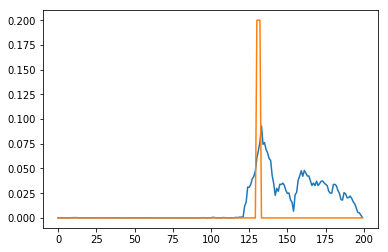

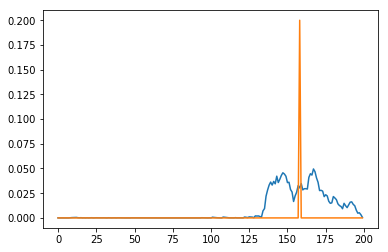

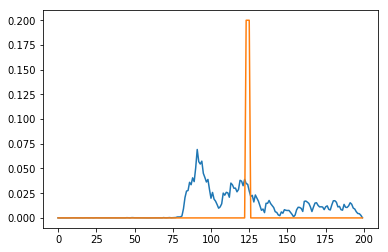

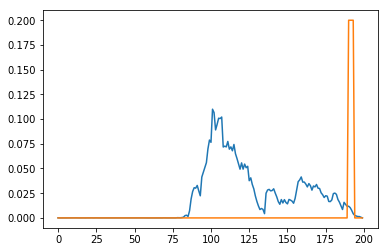

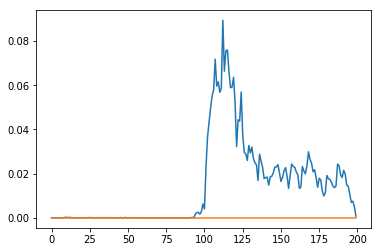

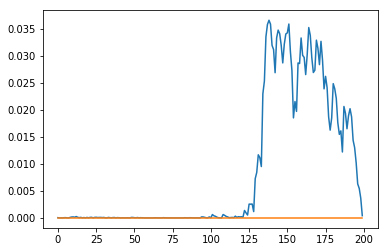

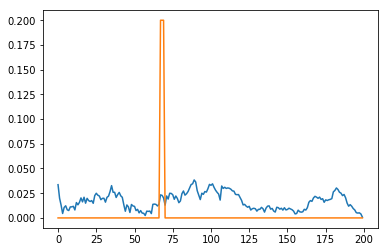

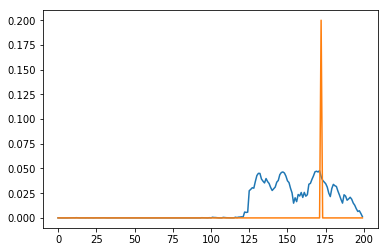

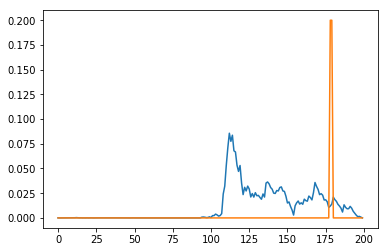

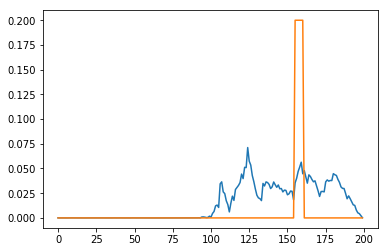

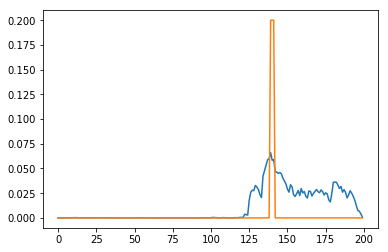

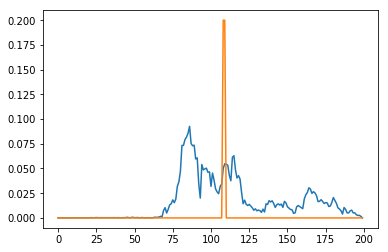

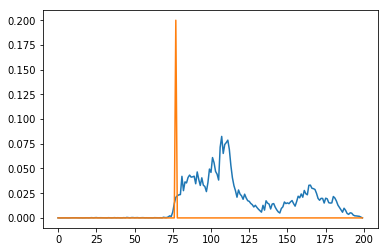

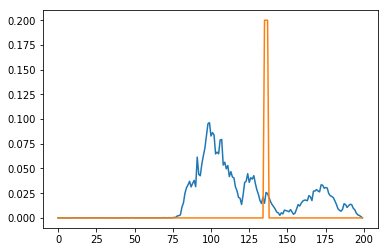

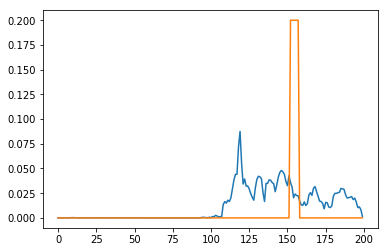

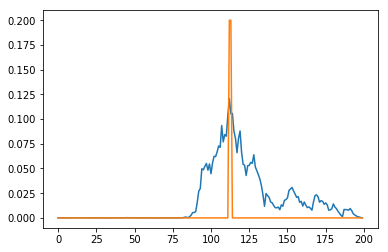

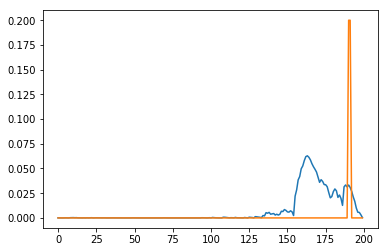

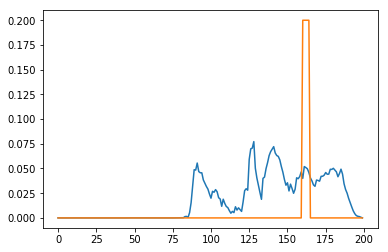

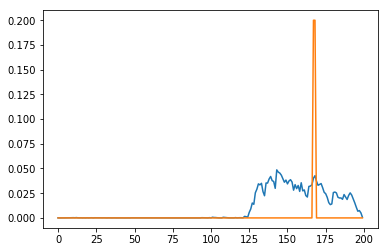

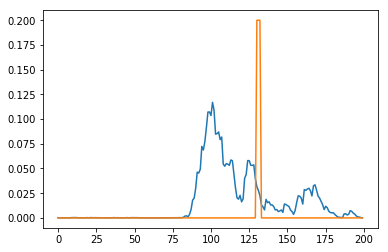

In [77]:
%matplotlib inline
%pylab inline
for i in range(batch):
    plt.plot(range(200), pred[i].reshape(200))
    plt.plot(range(200), real_arr[i])

    plt.show()

In [178]:
mask = pred > 0.09

predict = []
for i in range(len(val_sequences_1)):
    predict += [val_sequences_1[i][mask[i]]]

In [179]:
predict[0]

array([ 3182,     5,  3324, 15426,     2, 25770,  3836,  3665, 33643,
       38453,  1475,   962,   463,     3, 38478,  5317,  1336,  8667,
           2, 13692], dtype=int32)

In [180]:
def f1_score(prediction, ground_truth):
    if len(prediction) == 0:
        return 0
    if len(ground_truth) == 0:
        return 0
    precision = 1.0 * len(list(set(prediction) & set(ground_truth))) / len(prediction)
    recall = 1.0 * len(list(set(prediction) & set(ground_truth))) / len(ground_truth)
    if precision + recall != 0:
        f1 = (2 * precision * recall) / (precision + recall)
    else:
        f1 = 0
    return f1

In [136]:
f1_score(tmp, tmp1)

0.46153846153846156

In [181]:
f1_score(predict[0], val_sequences_3[0])

0.35714285714285715

In [182]:
f1 = []
for i in range(len(predict)):
    f1 += [f1_score(predict[i], val_sequences_3[i])]

In [183]:
np.array(f1).mean()

0.094258449787767276